In [1]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
import pywt
import matplotlib.pyplot as plt

In [2]:
# Helper function for D-Markov Machine state construction
def construct_d_markov_states(data, alphabet_size, D):
    """
    Constructs states for the D-Markov Machine.
    Args:
        data: The input symbolic time series data.
        alphabet_size: Size of the symbol alphabet.
        D: The order of the Markov machine.
    Returns:
        states: List of constructed states.
    """
    symbols = np.unique(data)
    states = {}

    # Generate states for the D-Markov Machine
    for i in range(len(data) - D):
        state = tuple(data[i:i + D])
        next_symbol = data[i + D]
        if state not in states:
            states[state] = np.zeros(alphabet_size)
        states[state][next_symbol] += 1

    # Normalize transitions
    for state in states:
        states[state] /= np.sum(states[state])

    return states

In [3]:
# Simulate the nonlinear electronic system based on the Duffing equation
def generate_time_series(beta_values, A, omega, sampling_rate, total_time):
    """
    Generate synthetic time series data based on the Duffing oscillator.
    Args:
        beta_values: List of dissipation parameter values (beta).
        A: Amplitude of the driving force.
        omega: Frequency of the driving force.
        sampling_rate: Sampling rate for time series generation.
        total_time: Total duration of the time series.
    Returns:
        time_series_data: Dictionary mapping beta values to corresponding time series.
    """
    time = np.arange(0, total_time, 1 / sampling_rate)
    time_series_data = {}

    for beta in beta_values:
        y = np.zeros(len(time))
        dy_dt = np.zeros(len(time))
        
        for i in range(1, len(time)):
            d2y_dt2 = -beta * dy_dt[i - 1] - y[i - 1] - y[i - 1]**3 + A * np.cos(omega * time[i])
            dy_dt[i] = dy_dt[i - 1] + d2y_dt2 * (1 / sampling_rate)
            y[i] = y[i - 1] + dy_dt[i] * (1 / sampling_rate)

        time_series_data[beta] = y

    return time_series_data

In [4]:
# Configuration for the experiments
beta_values = np.linspace(0.10, 0.35, 13)  # Beta values for experiments
A = 22.0  # Driving amplitude
omega = 5.0  # Driving frequency
sampling_rate = 100  # Hz
total_time = 30  # Seconds (extended for 2700 samples)

In [5]:
# Generate time series data
time_series_data = generate_time_series(beta_values, A, omega, sampling_rate, total_time)

# Preprocess the data
scaler = StandardScaler()
data_scaled = {beta: scaler.fit_transform(time_series.reshape(-1, 1)).flatten() 
               for beta, time_series in time_series_data.items()}

# Reshape data into a matrix with 270 segments of length 10
def reshape_to_segments(data, segment_length=10):
    num_segments = len(data) // segment_length
    return data[:num_segments * segment_length].reshape((num_segments, segment_length))

segmented_data = {beta: reshape_to_segments(data, segment_length=10) 
                  for beta, data in data_scaled.items()}

In [6]:
# Apply PCA to segmented data
pca_results = {}
for beta, segments in segmented_data.items():
    pca = PCA(n_components=2)  # Assuming at least 2 features in reshaped data
    pca_results[beta] = pca.fit_transform(segments)

# Use PCA results for anomaly detection
pca_anomaly_measures = {}
for beta, transformed_segments in pca_results.items():
    nominal_transformed = pca_results[0.10]  # Nominal beta transformed segments
    mse = mean_squared_error(nominal_transformed.flatten(), transformed_segments.flatten())
    pca_anomaly_measures[beta] = mse

# Normalize PCA anomaly measures
pca_anomaly_measures = {beta: value - pca_anomaly_measures[0.10] for beta, value in pca_anomaly_measures.items()}
max_pca = max(pca_anomaly_measures.values())
pca_anomaly_measures = {beta: value / max_pca for beta, value in pca_anomaly_measures.items()}

In [7]:
# Train MLP on nominal condition (beta = 0.10)
nominal_beta = 0.10
nominal_segments = segmented_data[nominal_beta]
X_nom = nominal_segments
y_nom = np.mean(nominal_segments, axis=1)  # Target can be adjusted based on context

mlp = MLPRegressor(hidden_layer_sizes=(50, 40, 30, 40), max_iter=1000, tol=1e-5, 
                    activation='tanh', random_state=42)
mlp.fit(X_nom, y_nom)

# Evaluate anomaly measures for MLP
mlp_anomaly_measures = {}
for beta, segments in segmented_data.items():
    X = segments
    y = np.mean(segments, axis=1)
    predictions = mlp.predict(X)
    mse = mean_squared_error(y, predictions)
    mlp_anomaly_measures[beta] = mse

# Normalize MLP anomaly measures
mlp_anomaly_measures = {beta: value - mlp_anomaly_measures[0.10] for beta, value in mlp_anomaly_measures.items()}
max_mlp = max(mlp_anomaly_measures.values())
mlp_anomaly_measures = {beta: value / max_mlp for beta, value in mlp_anomaly_measures.items()}

In [8]:
# Implement RBFNN for anomaly detection
kernel = RBF(length_scale=1.0)
gpr = GaussianProcessRegressor(kernel=kernel, random_state=42)
gpr.fit(X_nom, y_nom)

rbf_anomaly_measures = {}
for beta, segments in segmented_data.items():
    X = segments
    y = np.mean(segments, axis=1)
    predictions, _ = gpr.predict(X, return_std=True)
    mse = mean_squared_error(y, predictions)
    rbf_anomaly_measures[beta] = mse

# Normalize RBF anomaly measures
rbf_anomaly_measures = {beta: value - rbf_anomaly_measures[0.10] for beta, value in rbf_anomaly_measures.items()}
max_rbf = max(rbf_anomaly_measures.values())
rbf_anomaly_measures = {beta: value / max_rbf for beta, value in rbf_anomaly_measures.items()}

In [9]:
# Symbolic False Nearest Neighbors (SFNN) and Wavelet Space (WS) Methods
# SFNN Method
def symbolic_false_nearest_neighbors(data, alphabet_size):
    """Apply SFNN for partitioning time series into symbolic sequences."""
    bins = np.linspace(np.min(data), np.max(data), alphabet_size + 1)
    symbolic_sequence = np.digitize(data, bins) - 1
    return symbolic_sequence

# Wavelet Space Method
def wavelet_space_partitioning(data, wavelet='db1', alphabet_size=8):
    """Partition the data in wavelet space."""
    coeffs = pywt.wavedec(data, wavelet, level=1)
    flattened_coeffs = np.concatenate(coeffs)
    bins = np.linspace(np.min(flattened_coeffs), np.max(flattened_coeffs), alphabet_size + 1)
    symbolic_sequence = np.digitize(flattened_coeffs, bins) - 1
    return symbolic_sequence

sfnn_anomaly_measures = {}
ws_anomaly_measures = {}

for beta, data in data_scaled.items():
    symbolic_sfnn = symbolic_false_nearest_neighbors(data, alphabet_size=8)
    symbolic_ws = wavelet_space_partitioning(data, wavelet='db1', alphabet_size=8)

    # SFNN Anomaly Detection
    nominal_sfnn = symbolic_false_nearest_neighbors(data_scaled[nominal_beta], alphabet_size=8)
    sfnn_anomaly_measures[beta] = np.mean((symbolic_sfnn - nominal_sfnn)**2)

    # WS Anomaly Detection
    nominal_ws = wavelet_space_partitioning(data_scaled[nominal_beta], wavelet='db1', alphabet_size=8)
    ws_anomaly_measures[beta] = np.mean((symbolic_ws - nominal_ws)**2)

# Normalize SFNN and WS measures
sfnn_anomaly_measures = {beta: value - sfnn_anomaly_measures[0.10] for beta, value in sfnn_anomaly_measures.items()}
max_sfnn = max(sfnn_anomaly_measures.values())
sfnn_anomaly_measures = {beta: value / max_sfnn for beta, value in sfnn_anomaly_measures.items()}

ws_anomaly_measures = {beta: value - ws_anomaly_measures[0.10] for beta, value in ws_anomaly_measures.items()}
max_ws = max(ws_anomaly_measures.values())
ws_anomaly_measures = {beta: value / max_ws for beta, value in ws_anomaly_measures.items()}

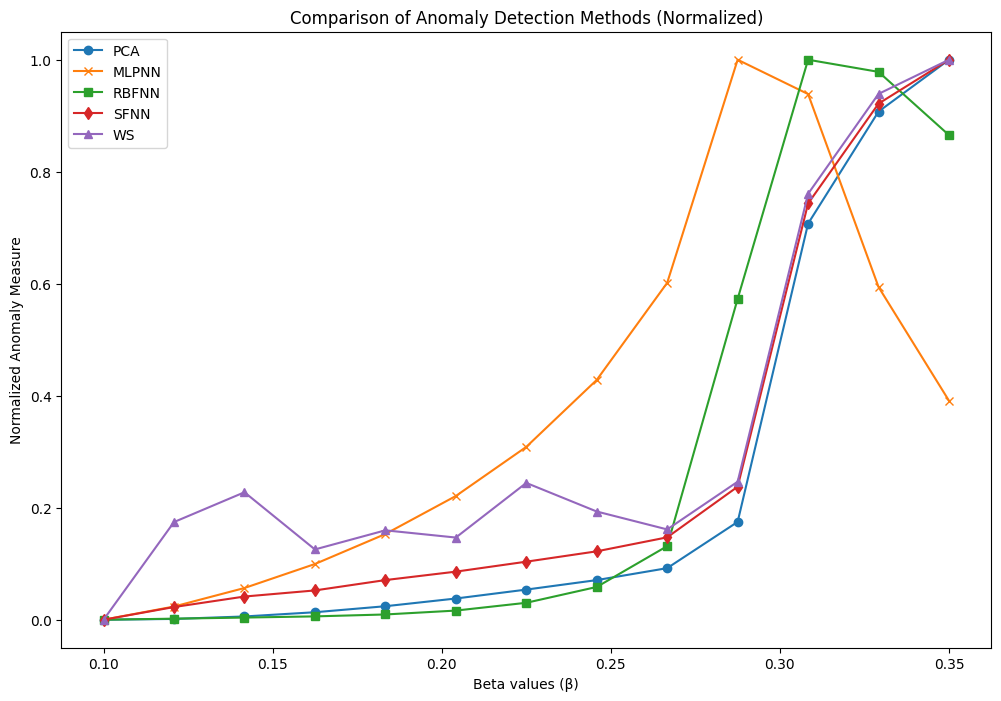

In [10]:
# Plot all anomaly measures
plt.figure(figsize=(12, 8))
plt.plot(list(pca_anomaly_measures.keys()), list(pca_anomaly_measures.values()), marker='o', label='PCA')
plt.plot(list(mlp_anomaly_measures.keys()), list(mlp_anomaly_measures.values()), marker='x', label='MLPNN')
plt.plot(list(rbf_anomaly_measures.keys()), list(rbf_anomaly_measures.values()), marker='s', label='RBFNN')
plt.plot(list(sfnn_anomaly_measures.keys()), list(sfnn_anomaly_measures.values()), marker='d', label='SFNN')
plt.plot(list(ws_anomaly_measures.keys()), list(ws_anomaly_measures.values()), marker='^', label='WS')
plt.xlabel('Beta values (β)')
plt.ylabel('Normalized Anomaly Measure')
plt.title('Comparison of Anomaly Detection Methods (Normalized)')
plt.legend()
plt.show()